<a href="https://colab.research.google.com/github/paulvern/Emulatori/blob/master/Dati_sensore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install plotly.express numpy pandas dash dash_html_components sklearn.preprocessing lmfit kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:00:00


In [ ]:
import plotly.express as px
import requests
import pandas as pd
import numpy as np
import os

def download_csv_from_google_drive(file_id, destination):
    URL = "https://drive.google.com/uc?export=download"

    # Parametri per la richiesta
    session = requests.Session()
    response = session.get(URL, params={'id': file_id}, stream=True)

    # Recupera il token di conferma se necessario
    token = get_confirm_token(response)

    if token:
        params = {'id': file_id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

# Funzione per ottenere il token di conferma
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

# Funzione per salvare il contenuto della risposta
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

# ID del file CSV pubblico su Google Drive
#file_id = '1Qxo94rsy_UQ1QaIplAyuAy6mj9Rg3ZKF'  #File completo
file_id='1A446w7Z4nE4SE5ql2LThuTYJRXsEHyL_' #file filtrato
destination = 'dati.csv'

# Scarica il file CSV
download_csv_from_google_drive(file_id, destination)
print("Download completato!")

# Leggi il file CSV in un DataFrame
dati = pd.read_csv(destination, sep=';')
dati = dati.apply(pd.to_numeric, errors='coerce')
print("File CSV letto in un DataFrame!")


#oppure leggo direttamente il foglio google con i campi calcolati
dati_completi="https://docs.google.com/spreadsheets/d/1wK43HGx7yNfUMlX87yfbkPHhD5J2-bOQANCbmBjaDas/export?format=csv"
df = pd.read_csv(dati_completi)
print(df.head())
dati=df
# Visualizza le prime righe del DataFrame
print(dati.head())
print(dati.dtypes)
des_sint=dati.describe(include='all')
des_sint.to_csv('des_sint.csv')
print(des_sint)

# forse è il caso di arrotondare le coordinate per una visualizzazione meno dispersa
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne
pd.set_option('display.max_colwidth', None)  # Mostra tutto il contenuto delle colonne
pd.set_option('display.width', 800)
# funzione create_3d_scatter_plot (volo,inquinante, arrotondamento_coordinate, dimensione_dei_punti, massimo_valore_della_scala_colorimetrica, tempo_inizio,tempo_fine,nome_file_salvataggio)
def create_3d_scatter_plot( vol,color_column,arrc,msize,maxc,start_time,end_time,output_html):
    # Crea un grafico scatter 3D con Plotly Express
    datipl=dati[(dati['volo']==vol)]

    datipl=datipl[(datipl['Time']>=start_time) & (datipl['Time']<=end_time)]

    datipl['Lat']=np.around(datipl['Lat'],arrc)
    datipl['Long']=np.around(datipl['Long'],arrc)
    print(datipl.tail())
    statistica=f'statistica descrittiva dell\'inquinante {color_column}'
    print(statistica)
    descrivi=(datipl.describe(include='all'))
    percorso="/content/drive/Shareddrives/DRONI e qualità dell'Aria/Elaborazioni/3d"
    descrivi.to_csv(f'{percorso}/descrivi_{color_column}_{vol}_{start_time}_{end_time}.csv')
    print(descrivi)
    fig = px.scatter_3d(datipl, x='Lat', y='Long', z='Delta_Z', color=color_column,color_continuous_scale=px.colors.sequential.Jet,
                        title=f"Grafico 3D di {color_column}",
                        labels={'lat': 'Lat', 'lon': 'Lon', 'Delta Z': 'Altezza',color_column: f'Valore di {color_column} non calibrato'},
                        width=1600, height=768, range_color=[dati[color_column].min(), maxc])
    fig.update_traces(marker=dict(size=msize))
    fig.update_layout(scene=dict(xaxis=dict(range=[44.64, 44.66])))
    fig.update_layout(scene=dict(yaxis=dict(range=[11.61, 11.63])))
    # Mostra il grafico
    fig.show()
    percorso="/content/drive/Shareddrives/DRONI e qualità dell'Aria/Elaborazioni/3d"
    fig.write_html(f"{percorso}/{output_html}")
    fig.write_html(output_html)
    output_img=os.path.splitext(output_html)[0] + '.png'
    fig.write_image(f"{percorso}/{output_img}")
    print(f"Grafico salvato come {output_html} e figura come {output_img}")
inqui_list=["PM10","PM25","O3","NO2","CO","VOC","CO2","T*10","U*10"]
for inqui in inqui_list:
  create_3d_scatter_plot('volo2',inqui,5,5,200,100000,120000,f"grafico3d{inqui}volo2.html")
for inqui in inqui_list:
  create_3d_scatter_plot('volo1',inqui,5,5,200,100000,120000,f"grafico3d{inqui}volo1.html")

Download completato!
File CSV letto in un DataFrame!
    volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori   Time  lat_ori  lon_ori  Lat_c1  Lat_c2        Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
0  volo1  477   271   630    999     101171    3018  250  787  634  441     8     4   82105.0  82105  4439.23  1137.45      44   39.23  44.653838      11   37.45  11.624095    12.827425  0.750090
1  volo1  477   271   628    999     101165    3031  250  785  630  444     8     4   82109.0  82109  4439.23  1137.45      44   39.23  44.653838      11   37.45  11.624088    13.327515  1.250179
2  volo1  476   272   631    999     101164    3043  249  782  626  447     8     4   82113.0  82113  4439.23  1137.45      44   39.23  44.653835      11   37.45  11.624090    13.410866  1.333530
3  volo1  474   272   631    999     101167    3043  247  777  621  443     5     3   82117.0  82117  4439.23  1137.45      44   39.23  44.653840      11   37.45  

Grafico salvato come grafico3dPM10volo2.html e figura come grafico3dPM10volo2.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2    Long  Delta_Z_ori   Delta_Z
5472  volo2  484   306   549    999     101193    3331  174   84  336  373     1     2  114433.0  114433  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    10.993968  4.165747
5473  volo2  483   306   553    999     101192    3331  175   83  336  373     1     2  114437.0  114437  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.077300  4.249079
5474  volo2  483   306   556    999     101189    3337  175   81  336  373     1     2  114441.0  114441  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.327300  4.499079
5475  volo2  481   306   556    999     101189    3337  176   81  336  378     1     1  114445.0  114445  4439.23  1137.44      44   3

Grafico salvato come grafico3dPM25volo2.html e figura come grafico3dPM25volo2.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2    Long  Delta_Z_ori   Delta_Z
5472  volo2  484   306   549    999     101193    3331  174   84  336  373     1     2  114433.0  114433  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    10.993968  4.165747
5473  volo2  483   306   553    999     101192    3331  175   83  336  373     1     2  114437.0  114437  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.077300  4.249079
5474  volo2  483   306   556    999     101189    3337  175   81  336  373     1     2  114441.0  114441  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.327300  4.499079
5475  volo2  481   306   556    999     101189    3337  176   81  336  378     1     1  114445.0  114445  4439.23  1137.44      44   3

Grafico salvato come grafico3dO3volo2.html e figura come grafico3dO3volo2.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2    Long  Delta_Z_ori   Delta_Z
5472  volo2  484   306   549    999     101193    3331  174   84  336  373     1     2  114433.0  114433  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    10.993968  4.165747
5473  volo2  483   306   553    999     101192    3331  175   83  336  373     1     2  114437.0  114437  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.077300  4.249079
5474  volo2  483   306   556    999     101189    3337  175   81  336  373     1     2  114441.0  114441  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.327300  4.499079
5475  volo2  481   306   556    999     101189    3337  176   81  336  378     1     1  114445.0  114445  4439.23  1137.44      44   39.23

Grafico salvato come grafico3dNO2volo2.html e figura come grafico3dNO2volo2.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2    Long  Delta_Z_ori   Delta_Z
5472  volo2  484   306   549    999     101193    3331  174   84  336  373     1     2  114433.0  114433  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    10.993968  4.165747
5473  volo2  483   306   553    999     101192    3331  175   83  336  373     1     2  114437.0  114437  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.077300  4.249079
5474  volo2  483   306   556    999     101189    3337  175   81  336  373     1     2  114441.0  114441  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.327300  4.499079
5475  volo2  481   306   556    999     101189    3337  176   81  336  378     1     1  114445.0  114445  4439.23  1137.44      44   39.

Grafico salvato come grafico3dCOvolo2.html e figura come grafico3dCOvolo2.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2    Long  Delta_Z_ori   Delta_Z
5472  volo2  484   306   549    999     101193    3331  174   84  336  373     1     2  114433.0  114433  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    10.993968  4.165747
5473  volo2  483   306   553    999     101192    3331  175   83  336  373     1     2  114437.0  114437  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.077300  4.249079
5474  volo2  483   306   556    999     101189    3337  175   81  336  373     1     2  114441.0  114441  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.327300  4.499079
5475  volo2  481   306   556    999     101189    3337  176   81  336  378     1     1  114445.0  114445  4439.23  1137.44      44   39.23

Grafico salvato come grafico3dVOCvolo2.html e figura come grafico3dVOCvolo2.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2    Long  Delta_Z_ori   Delta_Z
5472  volo2  484   306   549    999     101193    3331  174   84  336  373     1     2  114433.0  114433  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    10.993968  4.165747
5473  volo2  483   306   553    999     101192    3331  175   83  336  373     1     2  114437.0  114437  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.077300  4.249079
5474  volo2  483   306   556    999     101189    3337  175   81  336  373     1     2  114441.0  114441  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.327300  4.499079
5475  volo2  481   306   556    999     101189    3337  176   81  336  378     1     1  114445.0  114445  4439.23  1137.44      44   39.

Grafico salvato come grafico3dCO2volo2.html e figura come grafico3dCO2volo2.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2    Long  Delta_Z_ori   Delta_Z
5472  volo2  484   306   549    999     101193    3331  174   84  336  373     1     2  114433.0  114433  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    10.993968  4.165747
5473  volo2  483   306   553    999     101192    3331  175   83  336  373     1     2  114437.0  114437  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.077300  4.249079
5474  volo2  483   306   556    999     101189    3337  175   81  336  373     1     2  114441.0  114441  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.327300  4.499079
5475  volo2  481   306   556    999     101189    3337  176   81  336  378     1     1  114445.0  114445  4439.23  1137.44      44   39.

Grafico salvato come grafico3dT*10volo2.html e figura come grafico3dT*10volo2.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2    Long  Delta_Z_ori   Delta_Z
5472  volo2  484   306   549    999     101193    3331  174   84  336  373     1     2  114433.0  114433  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    10.993968  4.165747
5473  volo2  483   306   553    999     101192    3331  175   83  336  373     1     2  114437.0  114437  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.077300  4.249079
5474  volo2  483   306   556    999     101189    3337  175   81  336  373     1     2  114441.0  114441  4439.23  1137.44      44   39.23  44.65376      11   37.44  11.624    11.327300  4.499079
5475  volo2  481   306   556    999     101189    3337  176   81  336  378     1     1  114445.0  114445  4439.23  1137.44      44   3

Grafico salvato come grafico3dU*10volo2.html e figura come grafico3dU*10volo2.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2      Long  Delta_Z_ori    Delta_Z
3007  volo1  446   332   502    999     100964    3537  173   82  339  382     5     2  114225.0  114225  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.094416  18.017080
3008  volo1  446   333   502    999     100965    3537  172   80  338  378     5     2  114229.0  114229  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3009  volo1  447   333   503    999     100965    3537  172   79  337  377     5     2  114233.0  114233  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3010  volo1  447   333   503    999     100969    3537  173   82  337  383     6     3  114237.0  114237  4439.23  1137.44

Grafico salvato come grafico3dPM10volo1.html e figura come grafico3dPM10volo1.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2      Long  Delta_Z_ori    Delta_Z
3007  volo1  446   332   502    999     100964    3537  173   82  339  382     5     2  114225.0  114225  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.094416  18.017080
3008  volo1  446   333   502    999     100965    3537  172   80  338  378     5     2  114229.0  114229  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3009  volo1  447   333   503    999     100965    3537  172   79  337  377     5     2  114233.0  114233  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3010  volo1  447   333   503    999     100969    3537  173   82  337  383     6     3  114237.0  114237  4439.23  1137.44

Grafico salvato come grafico3dPM25volo1.html e figura come grafico3dPM25volo1.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2      Long  Delta_Z_ori    Delta_Z
3007  volo1  446   332   502    999     100964    3537  173   82  339  382     5     2  114225.0  114225  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.094416  18.017080
3008  volo1  446   333   502    999     100965    3537  172   80  338  378     5     2  114229.0  114229  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3009  volo1  447   333   503    999     100965    3537  172   79  337  377     5     2  114233.0  114233  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3010  volo1  447   333   503    999     100969    3537  173   82  337  383     6     3  114237.0  114237  4439.23  1137.44

Grafico salvato come grafico3dO3volo1.html e figura come grafico3dO3volo1.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2      Long  Delta_Z_ori    Delta_Z
3007  volo1  446   332   502    999     100964    3537  173   82  339  382     5     2  114225.0  114225  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.094416  18.017080
3008  volo1  446   333   502    999     100965    3537  172   80  338  378     5     2  114229.0  114229  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3009  volo1  447   333   503    999     100965    3537  172   79  337  377     5     2  114233.0  114233  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3010  volo1  447   333   503    999     100969    3537  173   82  337  383     6     3  114237.0  114237  4439.23  1137.44    

Grafico salvato come grafico3dNO2volo1.html e figura come grafico3dNO2volo1.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2      Long  Delta_Z_ori    Delta_Z
3007  volo1  446   332   502    999     100964    3537  173   82  339  382     5     2  114225.0  114225  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.094416  18.017080
3008  volo1  446   333   502    999     100965    3537  172   80  338  378     5     2  114229.0  114229  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3009  volo1  447   333   503    999     100965    3537  172   79  337  377     5     2  114233.0  114233  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3010  volo1  447   333   503    999     100969    3537  173   82  337  383     6     3  114237.0  114237  4439.23  1137.44  

Grafico salvato come grafico3dCOvolo1.html e figura come grafico3dCOvolo1.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2      Long  Delta_Z_ori    Delta_Z
3007  volo1  446   332   502    999     100964    3537  173   82  339  382     5     2  114225.0  114225  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.094416  18.017080
3008  volo1  446   333   502    999     100965    3537  172   80  338  378     5     2  114229.0  114229  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3009  volo1  447   333   503    999     100965    3537  172   79  337  377     5     2  114233.0  114233  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3010  volo1  447   333   503    999     100969    3537  173   82  337  383     6     3  114237.0  114237  4439.23  1137.44    

Grafico salvato come grafico3dVOCvolo1.html e figura come grafico3dVOCvolo1.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2      Long  Delta_Z_ori    Delta_Z
3007  volo1  446   332   502    999     100964    3537  173   82  339  382     5     2  114225.0  114225  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.094416  18.017080
3008  volo1  446   333   502    999     100965    3537  172   80  338  378     5     2  114229.0  114229  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3009  volo1  447   333   503    999     100965    3537  172   79  337  377     5     2  114233.0  114233  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3010  volo1  447   333   503    999     100969    3537  173   82  337  383     6     3  114237.0  114237  4439.23  1137.44  

Grafico salvato come grafico3dCO2volo1.html e figura come grafico3dCO2volo1.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2      Long  Delta_Z_ori    Delta_Z
3007  volo1  446   332   502    999     100964    3537  173   82  339  382     5     2  114225.0  114225  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.094416  18.017080
3008  volo1  446   333   502    999     100965    3537  172   80  338  378     5     2  114229.0  114229  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3009  volo1  447   333   503    999     100965    3537  172   79  337  377     5     2  114233.0  114233  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3010  volo1  447   333   503    999     100969    3537  173   82  337  383     6     3  114237.0  114237  4439.23  1137.44  

Grafico salvato come grafico3dT*10volo1.html e figura come grafico3dT*10volo1.png
       volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori    Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2      Long  Delta_Z_ori    Delta_Z
3007  volo1  446   332   502    999     100964    3537  173   82  339  382     5     2  114225.0  114225  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.094416  18.017080
3008  volo1  446   333   502    999     100965    3537  172   80  338  378     5     2  114229.0  114229  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3009  volo1  447   333   503    999     100965    3537  172   79  337  377     5     2  114233.0  114233  4439.23  1137.44      44   39.23  44.65379      11   37.44  11.62404    30.010932  17.933596
3010  volo1  447   333   503    999     100969    3537  173   82  337  383     6     3  114237.0  114237  4439.23  1137.44

Grafico salvato come grafico3dU*10volo1.html e figura come grafico3dU*10volo1.png


In [ ]:
import plotly.graph_objects as go
def create_2d_scatter_plot(vol,color_column,arrc,msize,maxc,start_time,end_time,output_html):
    datipl=dati[(dati['volo']==vol)]

    datipl=datipl[(datipl['Time']>=start_time) & (datipl['Time']<=end_time)]

    datipl['Lat']=np.around(datipl['Lat'],arrc)
    datipl['Time'] = pd.to_datetime(datipl['Time'], format='%H%M%S').dt.time

    fig = px.scatter(datipl, x='Time', y='Delta_Z',
                 color=color_column, color_continuous_scale=px.colors.sequential.Jet,
                 title='Grafico 2D',
                 labels={color_column: f'Valore di {color_column} non calibrato', 'Delta_Z': 'Altezza'},
                 width=1600, height=768, range_color=[dati[color_column].min(), maxc])
    datipl['Lat']=np.around(datipl['Lat'],arrc)
    datipl['Long']=np.around(datipl['Long'],arrc)
    fig.update_traces(marker=dict(size=msize))
    fig = go.Figure(fig.data)
    fig.add_trace(go.Scatter(
    x=datipl['Time'],
    y=datipl['T*10']/10,
    mode='lines',
    line=dict(color='red'),
    name='Temperatura'
    ))
    fig.add_trace(go.Scatter(
    x=datipl['Time'],
    y=datipl['U*10']/10,
    mode='lines',
    line=dict(color='yellow'),
    name='Umidità'
    ))
    fig.update_layout(
    title=f"Grafico 2D di {vol} - {color_column} dalle {start_time} alle {end_time}",
    xaxis_title='Tempo',
    yaxis_title='Valori',
    width=1600,
    height=768,
    legend=dict(
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    )
    )
    # Mostra il grafico
    fig.show()
    percorso="/content/drive/Shareddrives/DRONI e qualità dell'Aria/Elaborazioni/voli"
    fig.write_html(f"{percorso}/{output_html}")
    output_img=os.path.splitext(output_html)[0] + '.png'
    fig.write_image(f"{percorso}/{output_img}")
inqui_list=["PM10","PM25","O3","NO2","CO","VOC","CO2"]
for inqui in inqui_list:
  create_2d_scatter_plot('volo2',inqui,5,5,200,100000,120000,f"grafico{inqui}volo2.html")
for inqui in inqui_list:
  create_2d_scatter_plot('volo1',inqui,5,5,200,100000,120000,f"grafico{inqui}volo1.html")


In [ ]:
import plotly.graph_objects as go
def create_2d_scatter_plot_sd(vol,color_column,arrc,msize,maxc,start_time,end_time,output_html):
    datipl=dati[(dati['volo']==vol)]
    datipl=datipl[(datipl['Time']>=start_time) & (datipl['Time']<=end_time)]
    datipl['Lat']=np.around(datipl['Lat'],arrc)
    datipl['Time'] = datipl['Time'].astype(str)

    datipl['Time'] = datipl['Time'].apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:]}")

    datipl['Time'] = pd.to_datetime(datipl['Time'], format='%H:%M:%S')
    datipl.drop(datipl.columns[0], axis=1,inplace=True) #elimino la colonna di testo
    print(datipl.head())
    # Creiamo una colonna con il valore medio di Delta_Z per ogni intervallo di 1 minuto
    datipl.set_index('Time', inplace=True)
    datipl_resampled = datipl.resample('1T').std().dropna().reset_index()

    datipl_resampled_mean = datipl.resample('1T').mean().dropna().reset_index()

    # Uniamo le due tabelle sulla colonna time_column per ottenere sia la media che la deviazione standard
    datipl_combined = pd.merge(datipl_resampled_mean, datipl_resampled[['Time', 'Delta_Z',color_column]], on='Time', suffixes=('_mean', '_std'))
    datipl_combined['Time'] = datipl_combined['Time'].dt.strftime('%H:%M:%S')
    percorso="/content/drive/Shareddrives/DRONI e qualità dell'Aria/Elaborazioni/devstd"
    datipl_combined.to_csv(f'{percorso}/datipl_combined_{color_column}_{vol}_{start_time}_{end_time}.csv')

    print(datipl_combined)
    # Creiamo il grafico a dispersione
    fig = px.scatter(
    datipl_combined,
    x='Time',
    y='Delta_Z_mean',
    color=f'{color_column}_std',
    color_continuous_scale=px.colors.sequential.Jet,
    range_color=[datipl_combined[f'{color_column}_std'].min(), maxc],
    labels={
        'time_column': 'Tempo',
        'Delta_Z_mean': 'Delta_Z'
    },
    title=f"Dev. St. di {color_column} in {vol} dalle {start_time} alle {end_time}"
    )

# Mostriamo il grafico
    fig.show()

    fig.write_html(f"{percorso}/{output_html}")
    output_img=os.path.splitext(output_html)[0] + '.png'
    fig.write_image(f"{percorso}/{output_img}")
inqui_list=["PM10","PM25","O3","NO2","CO","VOC","CO2"]
for inqui in inqui_list:
  create_2d_scatter_plot_sd('volo1',inqui,5,5,5,100000,120000,f"grafico{inqui}_volo1_std.html")
for inqui in inqui_list:
  create_2d_scatter_plot_sd('volo2',inqui,5,5,5,100000,120000,f"grafico{inqui}_volo2_std.html")

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
1477  446   344   497    999     101072    3662  180  131  336  389     6     3  100001.0 1900-01-01 10:00:01   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1478  447   344   490    999     101071    3662  178  131  336  387     6     3  100005.0 1900-01-01 10:00:05   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.165391  9.088056
1479  446   344   490    999     101072    3662  178  131  336  388     6     3  100009.0 1900-01-01 10:00:09   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1480  446   344   488    999     101072    3662  178  131  336  386     6     3  100013.0 1900-01-01 10:00:13   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
1477  446   344   497    999     101072    3662  180  131  336  389     6     3  100001.0 1900-01-01 10:00:01   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1478  447   344   490    999     101071    3662  178  131  336  387     6     3  100005.0 1900-01-01 10:00:05   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.165391  9.088056
1479  446   344   490    999     101072    3662  178  131  336  388     6     3  100009.0 1900-01-01 10:00:09   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1480  446   344   488    999     101072    3662  178  131  336  386     6     3  100013.0 1900-01-01 10:00:13   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
1477  446   344   497    999     101072    3662  180  131  336  389     6     3  100001.0 1900-01-01 10:00:01   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1478  447   344   490    999     101071    3662  178  131  336  387     6     3  100005.0 1900-01-01 10:00:05   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.165391  9.088056
1479  446   344   490    999     101072    3662  178  131  336  388     6     3  100009.0 1900-01-01 10:00:09   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1480  446   344   488    999     101072    3662  178  131  336  386     6     3  100013.0 1900-01-01 10:00:13   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
1477  446   344   497    999     101072    3662  180  131  336  389     6     3  100001.0 1900-01-01 10:00:01   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1478  447   344   490    999     101071    3662  178  131  336  387     6     3  100005.0 1900-01-01 10:00:05   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.165391  9.088056
1479  446   344   490    999     101072    3662  178  131  336  388     6     3  100009.0 1900-01-01 10:00:09   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1480  446   344   488    999     101072    3662  178  131  336  386     6     3  100013.0 1900-01-01 10:00:13   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
1477  446   344   497    999     101072    3662  180  131  336  389     6     3  100001.0 1900-01-01 10:00:01   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1478  447   344   490    999     101071    3662  178  131  336  387     6     3  100005.0 1900-01-01 10:00:05   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.165391  9.088056
1479  446   344   490    999     101072    3662  178  131  336  388     6     3  100009.0 1900-01-01 10:00:09   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1480  446   344   488    999     101072    3662  178  131  336  386     6     3  100013.0 1900-01-01 10:00:13   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
1477  446   344   497    999     101072    3662  180  131  336  389     6     3  100001.0 1900-01-01 10:00:01   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1478  447   344   490    999     101071    3662  178  131  336  387     6     3  100005.0 1900-01-01 10:00:05   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.165391  9.088056
1479  446   344   490    999     101072    3662  178  131  336  388     6     3  100009.0 1900-01-01 10:00:09   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1480  446   344   488    999     101072    3662  178  131  336  386     6     3  100013.0 1900-01-01 10:00:13   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
1477  446   344   497    999     101072    3662  180  131  336  389     6     3  100001.0 1900-01-01 10:00:01   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1478  447   344   490    999     101071    3662  178  131  336  387     6     3  100005.0 1900-01-01 10:00:05   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.165391  9.088056
1479  446   344   490    999     101072    3662  178  131  336  388     6     3  100009.0 1900-01-01 10:00:09   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    21.081979  9.004643
1480  446   344   488    999     101072    3662  178  131  336  386     6     3  100013.0 1900-01-01 10:00:13   4439.2  1137.43      44    39.2  44.65336      11   37.43  11.623807    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
3909  435   310   538    999     101213    3293  175  118  325  356     2     2  100001.0 1900-01-01 10:00:01  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3910  435   309   532    999     101213    3300  178  119  325  362     2     2  100005.0 1900-01-01 10:00:05  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3911  435   309   532    999     101210    3300  175  116  324  353     2     2  100009.0 1900-01-01 10:00:09  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.577427  2.749206
3912  436   310   531    999     101217    3300  174  114  323  351     2     2  100013.0 1900-01-01 10:00:13  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
3909  435   310   538    999     101213    3293  175  118  325  356     2     2  100001.0 1900-01-01 10:00:01  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3910  435   309   532    999     101213    3300  178  119  325  362     2     2  100005.0 1900-01-01 10:00:05  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3911  435   309   532    999     101210    3300  175  116  324  353     2     2  100009.0 1900-01-01 10:00:09  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.577427  2.749206
3912  436   310   531    999     101217    3300  174  114  323  351     2     2  100013.0 1900-01-01 10:00:13  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
3909  435   310   538    999     101213    3293  175  118  325  356     2     2  100001.0 1900-01-01 10:00:01  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3910  435   309   532    999     101213    3300  178  119  325  362     2     2  100005.0 1900-01-01 10:00:05  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3911  435   309   532    999     101210    3300  175  116  324  353     2     2  100009.0 1900-01-01 10:00:09  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.577427  2.749206
3912  436   310   531    999     101217    3300  174  114  323  351     2     2  100013.0 1900-01-01 10:00:13  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
3909  435   310   538    999     101213    3293  175  118  325  356     2     2  100001.0 1900-01-01 10:00:01  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3910  435   309   532    999     101213    3300  178  119  325  362     2     2  100005.0 1900-01-01 10:00:05  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3911  435   309   532    999     101210    3300  175  116  324  353     2     2  100009.0 1900-01-01 10:00:09  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.577427  2.749206
3912  436   310   531    999     101217    3300  174  114  323  351     2     2  100013.0 1900-01-01 10:00:13  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
3909  435   310   538    999     101213    3293  175  118  325  356     2     2  100001.0 1900-01-01 10:00:01  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3910  435   309   532    999     101213    3300  178  119  325  362     2     2  100005.0 1900-01-01 10:00:05  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3911  435   309   532    999     101210    3300  175  116  324  353     2     2  100009.0 1900-01-01 10:00:09  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.577427  2.749206
3912  436   310   531    999     101217    3300  174  114  323  351     2     2  100013.0 1900-01-01 10:00:13  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
3909  435   310   538    999     101213    3293  175  118  325  356     2     2  100001.0 1900-01-01 10:00:01  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3910  435   309   532    999     101213    3300  178  119  325  362     2     2  100005.0 1900-01-01 10:00:05  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3911  435   309   532    999     101210    3300  175  116  324  353     2     2  100009.0 1900-01-01 10:00:09  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.577427  2.749206
3912  436   310   531    999     101217    3300  174  114  323  351     2     2  100013.0 1900-01-01 10:00:13  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845    

      CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori                Time  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori   Delta_Z
3909  435   310   538    999     101213    3293  175  118  325  356     2     2  100001.0 1900-01-01 10:00:01  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3910  435   309   532    999     101213    3300  178  119  325  362     2     2  100005.0 1900-01-01 10:00:05  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.327469  2.499249
3911  435   309   532    999     101210    3300  175  116  324  353     2     2  100009.0 1900-01-01 10:00:09  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845     9.577427  2.749206
3912  436   310   531    999     101217    3300  174  114  323  351     2     2  100013.0 1900-01-01 10:00:13  4439.19  1137.43      44   39.19  44.65323      11   37.43  11.623845    

In [ ]:
#proviamo a caricare i dati dei log
import requests
import pandas as pd
def download_csv_from_google_drive(file_id, destination):
    URL = "https://drive.google.com/uc?export=download"

    # Parametri per la richiesta
    session = requests.Session()
    response = session.get(URL, params={'id': file_id}, stream=True)

    # Recupera il token di conferma se necessario
    token = get_confirm_token(response)

    if token:
        params = {'id': file_id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

# Funzione per ottenere il token di conferma
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

# Funzione per salvare il contenuto della risposta
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

# ID del file CSV pubblico su Google Drive
#file_id = '1Qxo94rsy_UQ1QaIplAyuAy6mj9Rg3ZKF'  #File completo
file_id=['1ZfYgiKejmsDt8qF5R1-GZ4_vfOVRvbOm','1t4rd8P-vYVoeNk5NwQc1tvAhb0AwkrKe','1xicT40eYxhcKveQTTaC0QDRGEduYicZ0','11xfv96XI11PbgPquHRHGjGV0GCwB-gWt'] #file filtrato
destination = ['1_7_volo1.csv','1_7_volo2.csv','4_7_volo1.csv','4_7_volo2.csv']
dataframes = {}
for id_val, dest_val in zip(file_id, destination):
# Scarica il file CSV
  download_csv_from_google_drive(id_val, dest_val)
  df_name = dest_val.split('.')[0]  # Nome del DataFrame basato sul nome del file
  dataframes[df_name] = pd.read_csv(dest_val)
  print(dataframes[df_name].head())
  print(f"Download di {dest_val} completato")
dataframes['1_7_volo1']
dataframes['1_7_volo2']
dataframes['4_7_volo1']
dataframes['4_7_volo2']


   time(millisecond)        datetime(utc)   latitude  longitude  height_above_takeoff(feet) height_above_ground_at_drone_location(feet) ground_elevation_at_drone_location(feet)  altitude_above_seaLevel(feet)  height_sonar(feet)  speed(mph)  distance(feet)  mileage(feet)  satellites  gpslevel  voltage(v)  max_altitude(feet)  max_ascent(feet)  max_speed(mph)  max_distance(feet)   xSpeed(mph)   ySpeed(mph)   zSpeed(mph)   compass_heading(degrees)   pitch(degrees)   roll(degrees)  isPhoto  isVideo  rc_elevator  rc_aileron  rc_throttle  rc_rudder  rc_elevator(percent)  rc_aileron(percent)  rc_throttle(percent)  rc_rudder(percent)  gimbal_heading(degrees)  gimbal_pitch(degrees)  gimbal_roll(degrees)  battery_percent  voltageCell1  voltageCell2  voltageCell3  voltageCell4  voltageCell5  \
0                  0  2024-07-01 10:38:16  44.653814  11.623989                         0.0      Available with any HD 360 subscription   Available with any HD 360 subscription                      25.271369

,time(millisecond),datetime(utc),latitude,longitude,height_above_takeoff(feet),height_above_ground_at_drone_location(feet),ground_elevation_at_drone_location(feet),altitude_above_seaLevel(feet),height_sonar(feet),speed(mph),distance(feet),mileage(feet),satellites,gpslevel,voltage(v),max_altitude(feet),max_ascent(feet),max_speed(mph),max_distance(feet),xSpeed(mph),ySpeed(mph),zSpeed(mph),compass_heading(degrees),pitch(degrees),roll(degrees),isPhoto,isVideo,rc_elevator,rc_aileron,rc_throttle,rc_rudder,rc_elevator(percent),rc_aileron(percent),rc_throttle(percent),rc_rudder(percent),gimbal_heading(degrees),gimbal_pitch(degrees),gimbal_roll(degrees),battery_percent,voltageCell1,voltageCell2,voltageCell3,voltageCell4,voltageCell5,voltageCell6,current(A),battery_temperature(f),altitude(feet),ascent(feet),flycStateRaw,flycState,message
0,1550000,2024-07-04 11:06:26,44.653418,11.623944,0.0,Available with any HD 360 subscription,Available with any HD 360 subscription,25.991991,0.328084,0.0,0.000000,0.000000,31,10,0.000,25.991991,0.0000,0.000000,0.000000,0.0,0.0,0.0,199.6,-0.2,1.8,0,0,1024,1024,1024,1024,0,0,0,0,0,0,0,100,NaN,NaN,NaN,NaN,NaN,NaN,0.000,94.64,25.991991,0.0,41,Motors_Started,Your aircraft is flying in an Altitude Zone (500m). Please fly with caution.
1,1550100,2024-07-04 11:06:26,44.653418,11.623944,0.0,NaN,NaN,25.991991,0.328084,0.0,0.000941,0.000941,31,10,0.000,25.991991,0.0000,0.000000,0.000941,0.0,0.0,0.0,199.6,-0.2,1.8,0,0,364,423,364,1622,-100,-91,-100,91,0,0,0,100,NaN,NaN,NaN,NaN,NaN,NaN,0.000,94.64,25.991991,0.0,41,Motors_Started,NaN
2,1550200,2024-07-04 11:06:26,44.653418,11.623944,0.0,NaN,NaN,25.991991,0.328084,0.0,0.001772,0.003395,31,10,0.000,25.991991,0.0000,0.000000,0.001772,0.0,0.0,0.0,199.6,-0.2,1.8,0,0,364,424,364,1620,-100,-91,-100,90,0,0,0,100,NaN,NaN,NaN,NaN,NaN,NaN,0.000,94.64,25.991991,0.0,41,Motors_Started,NaN
3,1550300,2024-07-04 11:06:26,44.653418,11.623944,0.0,NaN,NaN,25.991991,0.328084,0.0,0.004479,0.006136,31,10,0.000,25.991991,0.0000,0.000000,0.004479,0.0,0.0,0.0,199.6,-0.2,1.8,0,0,364,424,364,1618,-100,-91,-100,90,0,0,0,100,NaN,NaN,NaN,NaN,NaN,NaN,0.000,94.64,25.991991,0.0,41,Motors_Started,Setting new Return-To-Home altitude to 45m (148 ft). Data Recorder File Index is 68. Setting new Maximum Flight Altitude to 125m (410 ft)
4,1550400,2024-07-04 11:06:26,44.653418,11.623944,0.0,NaN,NaN,25.991991,0.328084,0.0,0.003424,0.007939,31,10,0.000,25.991991,0.0000,0.000000,0.004479,0.0,0.0,0.0,199.6,-0.2,1.8,0,0,436,435,364,1604,-89,-89,-100,88,0,0,0,100,NaN,NaN,NaN,NaN,NaN,NaN,0.000,94.64,25.991991,0.0,41,Motors_Started,"Home Point recorded. Return-to-Home Altitude:45,0 m"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14707,3020800,2024-07-04 11:30:57,44.653796,11.623956,0.0,NaN,NaN,25.991991,0.656168,0.0,138.115490,2265.807159,31,10,21.366,419.692791,393.7008,8.052984,138.765424,0.0,0.0,0.0,90.0,0.6,-0.1,0,0,1024,1024,364,1024,0,0,-100,0,0,0,0,28,NaN,NaN,NaN,NaN,NaN,NaN,7.336,119.12,25.991991,0.0,33,Confirm_Landing,NaN
14708,3020900,2024-07-04 11:30:57,44.653796,11.623956,0.0,NaN,NaN,25.991991,0.656168,0.0,138.113521,2265.807159,31,10,21.366,419.692791,393.7008,8.052984,138.765424,0.0,0.0,0.0,90.0,0.6,-0.1,0,0,1024,1024,364,1024,0,0,-100,0,0,0,0,28,NaN,NaN,NaN,NaN,NaN,NaN,7.336,119.12,25.991991,0.0,33,Confirm_Landing,NaN
14709,3021000,2024-07-04 11:30:57,44.653796,11.623956,0.0,NaN,NaN,25.991991,0.656168,0.0,138.113193,2265.810440,31,10,21.366,419.692791,393.7008,8.052984,138.765424,0.0,0.0,0.0,90.0,0.6,-0.1,0,0,1024,1024,364,1024,0,0,-100,0,0,0,0,28,NaN,NaN,NaN,NaN,NaN,NaN,7.336,119.12,25.991991,0.0,33,Confirm_Landing,NaN
14710,3021100,2024-07-04 11:30:57,44.653796,11.623956,0.0,NaN,NaN,25.991991,0.656168,0.0,138.109913,2265.813721,31,10,21.366,419.692791,393.7008,8.052984,138.765424,0.0,0.0,0.0,89.9,0.6,-0.1,0,0,1024,1024,364,1024,0,0,-

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
def confronta_altezza(voloesteso, voloscelto):

  df = dataframes[voloesteso]
  df['datetime(utc)']=pd.to_datetime(df['datetime(utc)'])
  df['Time'] = df['datetime(utc)'].dt.strftime('%H%M%S').astype(int)
  #print(df['Time'])
  df_unique = df.drop_duplicates(subset='Time', keep='first')
  df_unique = df_unique[['Time', 'height_above_takeoff(feet)']]
  #print(df_unique['height_above_takeoff(feet)'])
  #print(dati.head())
  merged_df = pd.merge(df_unique, dati, on='Time')
  merged_df['height_meters'] = merged_df['height_above_takeoff(feet)'] * 0.3048
  #print(merged_df.head())
  print(merged_df.tail())
  #print()
  percorso="/content/drive/Shareddrives/DRONI e qualità dell'Aria/Elaborazioni/confrontoconlog"
  volo_name = voloesteso.split('.')[0]
  filtered_df = merged_df[merged_df['volo'] == voloscelto]
  filtered_df['Time'] = pd.to_datetime(filtered_df['Time'], format='%H%M%S').dt.time
  filtered_df.to_csv(f'{percorso}/{volo_name}_confronto_{voloscelto}.csv')

  # Stampa le righe filtrate
  print(filtered_df)


  fig = go.Figure()

  # Aggiungi il tracciato per 'height_meters'
  fig.add_trace(go.Scatter(
    x=filtered_df['Time'],
    y=filtered_df['height_meters'],
    mode='lines+markers',
    name='Height (meters)'
  ))

  # Aggiungi il tracciato per 'hei'
  fig.add_trace(go.Scatter(
    x=filtered_df['Time'],
    y=filtered_df['Delta_Z'],
    mode='lines+markers',
    name='Delta_Z'
  ))
  fig.update_layout(title=f"{voloesteso}_{voloscelto}")
  fig.show()


  fig.write_html(f"{percorso}/{volo_name}_confronto_{voloscelto}.html")
  fig.write_image(f"{percorso}/{volo_name}_confronto_{voloscelto}.png")


voloestesi1=['1_7_volo1','4_7_volo1']
voloestesi2=['1_7_volo2','4_7_volo2']
voloscelto=['volo1','volo2']
for voloest in voloestesi1:
   confronta_altezza(voloest,'volo1')
for voloest in voloestesi2:
   confronta_altezza(voloest,'volo2')


       Time  height_above_takeoff(feet)   volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori    Delta_Z  height_meters
782  110425                    7.217848  volo2  444   279   523    999     100769    3050  162   60  312  349     1     1  110425.0  4439.21  1137.43      44   39.21  44.65356      11   37.43  11.623813    46.386663  39.558442            2.2
783  110429                    2.296588  volo1  454   315   513    999     100983    3356  166   65  332  362     6     2  110429.0  4439.20  1137.43      44   39.20  44.65333      11   37.43  11.623872    28.508329  16.430993            0.7
784  110429                    2.296588  volo2  445   279   523    999     100769    3050  161   59  312  345     1     1  110429.0  4439.21  1137.43      44   39.21  44.65356      11   37.43  11.623813    46.386663  39.558442            0.7
785  110433                    0

       Time  height_above_takeoff(feet)   volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori  lat_ori  lon_ori  Lat_c1  Lat_c2       Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori    Delta_Z  height_meters
766  110525                    9.842520  volo2  446   279   527    999     101093    3093  162   64  314  352     1     1  110525.0  4439.21  1137.43      44   39.21  44.65356      11   37.43  11.623813    19.330466  12.502245            3.0
767  110529                    2.624672  volo1  451   316   553    999     100894    3387  166   72  337  359    31     6  110529.0  4439.20  1137.43      44   39.20  44.65333      11   37.43  11.623872    35.939981  23.862645            0.8
768  110529                    2.624672  volo2  446   280   527    999     101156    3093  163   64  314  353     1     1  110529.0  4439.21  1137.43      44   39.21  44.65356      11   37.43  11.623813    14.077695   7.249474            0.8
769  110533                    0

       Time  height_above_takeoff(feet)   volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori  lat_ori  lon_ori  Lat_c1  Lat_c2        Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori    Delta_Z  height_meters
731  112925                    6.889764  volo2  443   279   537    999     100925    3043  163   54  317  354     1     1  112925.0  4439.23  1137.42      44   39.23  44.653878      11   37.42  11.623588    33.350826  26.522605            2.1
732  112929                    2.296588  volo1  451   318   514    999     100963    3437  167   72  334  374     4     3  112929.0  4439.23  1137.44      44   39.23  44.653843      11   37.44  11.624003    30.177901  18.100565            0.7
733  112929                    2.296588  volo2  444   279   537    999     100992    3043  161   53  316  345     2     1  112929.0  4439.23  1137.42      44   39.23  44.653813      11   37.42  11.623642    27.757109  20.928888            0.7
734  112933                 

       Time  height_above_takeoff(feet)   volo  CO2  T*10  U*10  vuoto  Pressione  T*1000   O3  NO2   CO  VOC  PM10  PM25  Time_ori  lat_ori  lon_ori  Lat_c1  Lat_c2        Lat  Lon_c1  Lon_c2       Long  Delta_Z_ori    Delta_Z  height_meters
729  113049                    2.624672  volo2  444   281   575    999     101199    3068  164   62  323  363     2     2  113049.0  4439.23  1137.44      44   39.23  44.653853      11   37.44  11.623928    10.493991   3.665770            0.8
730  113053                    2.296588  volo1  455   320   524    999     100978    3431  169   83  337  381     8     3  113053.0  4439.21  1137.45      44   39.21  44.653527      11   37.44  11.624083    28.925697  16.848361            0.7
731  113053                    2.296588  volo2  444   281   575    999     101198    3068  165   62  324  364     2     2  113053.0  4439.23  1137.44      44   39.23  44.653853      11   37.44  11.623928    10.577319   3.749098            0.7
732  113057                 

In [ ]:
import plotly.figure_factory as ff

def show_correlation_matrix(dataframe, title):
    # Calcoliamo la matrice di correlazione
    variables_to_include = ['CO2','T*10',"U*10","Pressione","T*1000","O3","NO2","CO","VOC","PM10","PM25"]

    correlation_matrix = dataframe.corr()

    # Creiamo una tabella dalla matrice di correlazione
    table = ff.create_table(correlation_matrix.round(2), height_constant=30)

    # Aggiorniamo il layout della tabella
    table.update_layout(title=title)

    # Mostriamo la tabella
    table.show()

show_correlation_matrix(dati, "Matrice di correlazione")


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 523
    # variables        = 3
    chi-square         = 23179.0000
    reduced chi-square = 44.5750000
    Akaike info crit   = 1988.91293
    Bayesian info crit = 2001.69167
    R-squared          = -1.95093762
##  Warning: uncertainties could not be estimated:
    amp:  at initial value
    cen:  at initial value
    wid:  at initial value
[[Variables]]
    amp:  3.00000000 (init = 3)
    cen:  3.00000000 (init = 3)
    wid:  1.00000000 (init = 1)


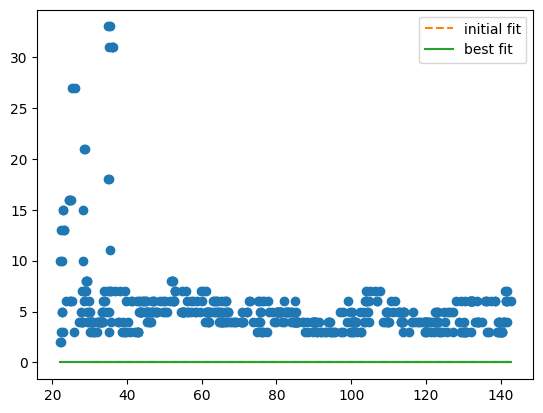

In [ ]:
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt
from lmfit import Model

data = dati
x = data['Delta_Z']
y = data['PM10']


def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=3, cen=3, wid=1)

print(result.fit_report())

plt.plot(x, y, 'o')
plt.plot(x, result.init_fit, '--', label='initial fit')
plt.plot(x, result.best_fit, '-', label='best fit')
plt.legend()
plt.show()